In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1320 sha256=623d065dfca2e759adeab9d824ca3309803925fbe63bdc8db9b11b57c4d3b13c
  Stored in directory: c:\users\phoec\appdata\local\pip\cache\wheels\46\ef\c3\157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -U scikit-learn

  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1
Note: you may need to restart the kernel to use updated packages.


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\phoec\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\phoec\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\phoec\AppData\Roaming\nltk_data...


True

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import sklearn.exceptions
from sklearn.ensemble import StackingClassifier
print(sklearn.__version__)

0.24.1


In [10]:
pwd = os.getcwd()
dataset = pd.read_csv(pwd+"/train.csv")

In [11]:
df = dataset.copy()

In [12]:
df.head()

,tweettextcleaned,sentiment
0,Good afternoon everyone! If anyone has any cha...,2
1,There are roughly 250 trading days a year - $1...,2
2,"Thanks for the mention, DT! Hagw",2
3,Thanks Panda Have a great weekend everyone!,2
4,Thank you for the mention TS! We look forward ...,2


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1175 entries, 0 to 1174
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweettextcleaned  1161 non-null   object
 1   sentiment         1175 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.5+ KB


In [14]:
df.sentiment.value_counts()

1    464
2    435
0    276
Name: sentiment, dtype: int64

In [15]:
df.isnull().values.any()

True

In [16]:
df = df[df['sentiment']!=1]
df.sentiment.value_counts()

2    435
0    276
Name: sentiment, dtype: int64

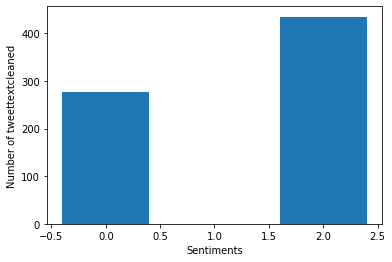

In [17]:
Sentiment_count=df.groupby('sentiment').count()
plt.bar(Sentiment_count.index.values, Sentiment_count['tweettextcleaned'])
plt.xlabel('Sentiments')
plt.ylabel('Number of tweettextcleaned')
plt.show()

In [18]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?","'", ".", ";", ":",  "!",'"'))
    return final

In [19]:
#preprocessing
#remove non-alphabetic characters, convert to lowercase, remove stopwords, stemming

df['tweettextcleaned'] = df['tweettextcleaned'].apply(remove_punctuation)
df['tweettextcleaned'] = df['tweettextcleaned'].str.lower()
df['tweettextcleaned'] = df['tweettextcleaned'].str.split()
stop_words = set(stopwords.words('english')) 
df['tweettextcleaned'] = df['tweettextcleaned'].apply(lambda x: " ".join(x for x in x if x not in stop_words))
df['tweettextcleaned'] = df['tweettextcleaned'].apply(lambda x: word_tokenize(x))
stemmer = PorterStemmer()
df['tweettextcleaned'] = df['tweettextcleaned'].apply(lambda x: [stemmer.stem(y) for y in x])
df['tweettextcleaned'] = df['tweettextcleaned'].apply(lambda x: " ".join(x for x in x))

In [20]:
#count vectorizer
cv = CountVectorizer(analyzer=lambda x: x) #disable analyzer
df['cv'] = cv.fit_transform(df['tweettextcleaned'])

In [21]:
#tfidf conversion
tfidf_vectorizer=TfidfVectorizer(use_idf=True) 
df['tfidf']=tfidf_vectorizer.fit_transform(df['tweettextcleaned'])

In [22]:
#VADER
#pre-trained sentiment analyzer
vader = SentimentIntensityAnalyzer()
# Iterate through the headlines and get the polarity scores using vader
scores = df['tweettextcleaned'].apply(vader.polarity_scores).tolist()
# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)
# Join the DataFrames of the news and the list of dicts
df1 = df.join(scores_df, rsuffix='_right')
df1.head()

,tweettextcleaned,sentiment,cv,tfidf,neg,neu,pos,compound
0,"good afternoon everyon anyon chart request , q...",2,"(0, 28)\t6\n (0, 36)\t12\n (0, 25)\t4\n (...","(0, 1959)\t0.15168924699448372\n (0, 2442)\...",0.0,0.819,0.181,0.7351
1,roughli 250 trade day year - $ 100 day = 25k -...,2,"(0, 28)\t6\n (0, 36)\t12\n (0, 25)\t4\n (...","(0, 1959)\t0.15168924699448372\n (0, 2442)\...",0.0,1.000,0.000,0.0000
2,"thank mention , dt hagw",2,"(0, 28)\t6\n (0, 36)\t12\n (0, 25)\t4\n (...","(0, 1959)\t0.15168924699448372\n (0, 2442)\...",0.0,0.545,0.455,0.3612
3,thank panda great weekend everyon,2,"(0, 28)\t6\n (0, 36)\t12\n (0, 25)\t4\n (...","(0, 1959)\t0.15168924699448372\n (0, 2442)\...",0.0,0.312,0.688,0.7650
4,thank mention ts look forward show weekend hagw,2,"(0, 28)\t6\n (0, 36)\t12\n (0, 25)\t4\n (...","(0, 1959)\t0.15168924699448372\n (0, 2442)\...",0.0,0.737,0.263,0.3612


In [23]:
tf=TfidfVectorizer()
text_tf= tf.fit_transform(df['tweettextcleaned'])
X_train, X_test, y_train, y_test = train_test_split(text_tf, df['sentiment'], test_size=0.3, random_state=123)

In [24]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    DecisionTreeClassifier(),
    GradientBoostingClassifier(),
    KNeighborsClassifier(n_neighbors=7)
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    model.fit(X_train,y_train)
    predicted= model.predict(X_test)
    accuracies = cross_val_score(model, text_tf, df['sentiment'], scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    print("Accuracy of ",model_name,":",metrics.accuracy_score(y_test, predicted))
    print("Classification Report of ",model_name,":\n",classification_report(y_test,predicted))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
print(cv_df.groupby('model_name').accuracy.mean())
print(cv_df)

Accuracy of  RandomForestClassifier : 0.6214953271028038
Classification Report of  RandomForestClassifier :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        81
           2       0.62      1.00      0.77       133

    accuracy                           0.62       214
   macro avg       0.31      0.50      0.38       214
weighted avg       0.39      0.62      0.48       214

Accuracy of  LinearSVC : 0.7757009345794392
Classification Report of  LinearSVC :
               precision    recall  f1-score   support

           0       0.78      0.57      0.66        81
           2       0.77      0.90      0.83       133

    accuracy                           0.78       214
   macro avg       0.78      0.74      0.75       214
weighted avg       0.78      0.78      0.77       214

Accuracy of  MultinomialNB : 0.7429906542056075
Classification Report of  MultinomialNB :
               precision    recall  f1-score   support

        

C:\Users\phoec\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phoec\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phoec\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of  DecisionTreeClassifier : 0.7429906542056075
Classification Report of  DecisionTreeClassifier :
               precision    recall  f1-score   support

           0       0.70      0.57      0.63        81
           2       0.76      0.85      0.80       133

    accuracy                           0.74       214
   macro avg       0.73      0.71      0.72       214
weighted avg       0.74      0.74      0.74       214

Accuracy of  GradientBoostingClassifier : 0.7897196261682243
Classification Report of  GradientBoostingClassifier :
               precision    recall  f1-score   support

           0       0.83      0.56      0.67        81
           2       0.78      0.93      0.85       133

    accuracy                           0.79       214
   macro avg       0.80      0.74      0.76       214
weighted avg       0.80      0.79      0.78       214

Accuracy of  KNeighborsClassifier : 0.7336448598130841
Classification Report of  KNeighborsClassifier :
               p

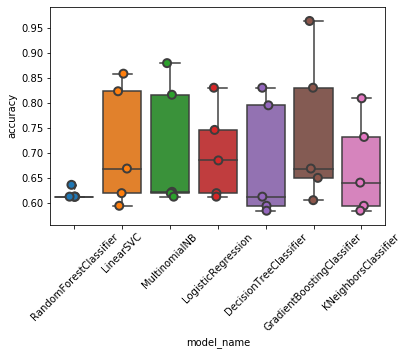

In [25]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.xticks(rotation=45)
plt.show()

## Logistic Regression

In [26]:
model = LogisticRegression()
model_name = model.__class__.__name__
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1', 'l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
classifier = RandomizedSearchCV(model, grid, cv=5, n_iter=200, random_state=0,scoring='accuracy', error_score=0, n_jobs=-1)
grid_search = classifier.fit(X_train, y_train)
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)
print("Best Trainset Accuracy: %.2f%% using %s" % (grid_search.best_score_*100,grid_search.best_params_))
print("Testset Accuracy: %.2f%% " % (accuracy_score(y_test, y_test_pred)*100))
print("Classification Report of ",model_name,":\n",classification_report(y_test,y_test_pred))
print("Accuracy of",model_name,":",metrics.accuracy_score(y_test, y_test_pred))

C:\Users\phoec\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 45 is smaller than n_iter=200. Running 45 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best Trainset Accuracy: 78.07% using {'solver': 'newton-cg', 'penalty': 'l2', 'C': 10}
Testset Accuracy: 78.04% 
Classification Report of  LogisticRegression :
               precision    recall  f1-score   support

           0       0.79      0.57      0.66        81
           2       0.78      0.91      0.84       133

    accuracy                           0.78       214
   macro avg       0.78      0.74      0.75       214
weighted avg       0.78      0.78      0.77       214

Accuracy of LogisticRegression : 0.780373831775701


## Decision Tree

In [27]:
model = DecisionTreeClassifier()
model_name = model.__class__.__name__
max_features = ['auto', 'sqrt']
max_depth = list(range(2,100))
max_depth.append(None)
min_samples_split = list(range(1, 16))
min_samples_leaf = list(range(1, 16))
criterion = ["gini", "entropy"]
grid = {'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'criterion': criterion}
classifier = RandomizedSearchCV(model, grid, cv=5, n_iter=200, random_state=0,scoring='accuracy', error_score=0, n_jobs=-1)
grid_search = classifier.fit(X_train, y_train)
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)
print("Best Trainset Accuracy: %.2f%% using %s" % (grid_search.best_score_*100,grid_search.best_params_))
print("Testset Accuracy: %.2f%% " % (accuracy_score(y_test, y_test_pred)*100))
print("Classification Report of ",model_name,":\n",classification_report(y_test,y_test_pred))
print("Accuracy of",model_name,":",metrics.accuracy_score(y_test, y_test_pred))

Best Trainset Accuracy: 73.04% using {'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 94, 'criterion': 'entropy'}
Testset Accuracy: 72.43% 
Classification Report of  DecisionTreeClassifier :
               precision    recall  f1-score   support

           0       0.66      0.57      0.61        81
           2       0.76      0.82      0.79       133

    accuracy                           0.72       214
   macro avg       0.71      0.69      0.70       214
weighted avg       0.72      0.72      0.72       214

Accuracy of DecisionTreeClassifier : 0.7242990654205608


## Random Forest

In [28]:
model = RandomForestClassifier()
model_name = model.__class__.__name__
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 3)]
max_features = ['auto', 'sqrt']
max_depth = [5,20,50, None]
min_samples_split = list(range(1, 16))
min_samples_leaf = list(range(1, 16))
bootstrap = [True, False]
criterion = ["gini", "entropy"]
grid = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap,
        'criterion': criterion}
classifier = RandomizedSearchCV(model, grid, cv=5, n_iter=200, random_state=0,scoring='accuracy', error_score=0, n_jobs=-1)
grid_search = classifier.fit(X_train, y_train)
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)
print("Best Trainset Accuracy: %.2f%% using %s" % (grid_search.best_score_*100,grid_search.best_params_))
print("Testset Accuracy: %.2f%% " % (accuracy_score(y_test, y_test_pred)*100))
print("Classification Report of ",model_name,":\n",classification_report(y_test,y_test_pred))
print("Accuracy of",model_name,":",metrics.accuracy_score(y_test, y_test_pred))

Best Trainset Accuracy: 78.07% using {'n_estimators': 150, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 50, 'criterion': 'entropy', 'bootstrap': False}
Testset Accuracy: 81.31% 
Classification Report of  RandomForestClassifier :
               precision    recall  f1-score   support

           0       0.87      0.59      0.71        81
           2       0.79      0.95      0.86       133

    accuracy                           0.81       214
   macro avg       0.83      0.77      0.78       214
weighted avg       0.82      0.81      0.80       214

Accuracy of RandomForestClassifier : 0.8130841121495327


## XGBoost

In [29]:
model = GradientBoostingClassifier()
model_name = model.__class__.__name__
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 3)]
learning_rate = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
max_depth = [5,20,50, None]
min_samples_split = list(range(1, 16))
min_samples_leaf = list(range(1, 16))
max_features = ['auto', 'sqrt']
grid = {'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'max_features': max_features}
classifier = RandomizedSearchCV(model, grid, cv=5, n_iter=200, random_state=0,scoring='accuracy', error_score=0, n_jobs=-1)
grid_search = classifier.fit(X_train, y_train)
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)
print("Best Trainset Accuracy: %.2f%% using %s" % (grid_search.best_score_*100,grid_search.best_params_))
print("Testset Accuracy: %.2f%% " % (accuracy_score(y_test, y_test_pred)*100))
print("Classification Report of ",model_name,":\n",classification_report(y_test,y_test_pred))
print("Accuracy of",model_name,":",metrics.accuracy_score(y_test, y_test_pred))

Best Trainset Accuracy: 77.26% using {'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'learning_rate': 0.05}
Testset Accuracy: 82.24% 
Classification Report of  GradientBoostingClassifier :
               precision    recall  f1-score   support

           0       0.91      0.59      0.72        81
           2       0.80      0.96      0.87       133

    accuracy                           0.82       214
   macro avg       0.85      0.78      0.79       214
weighted avg       0.84      0.82      0.81       214

Accuracy of GradientBoostingClassifier : 0.822429906542056


## Linear SVC

In [30]:
model = LinearSVC()
model_name = model.__class__.__name__
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("Testset Accuracy: %.2f%% " % (accuracy_score(y_test, y_test_pred)*100))
print("Classification Report of ",model_name,":\n",classification_report(y_test,y_test_pred))
print("Accuracy of",model_name,":",metrics.accuracy_score(y_test, y_test_pred))

Testset Accuracy: 77.57% 
Classification Report of  LinearSVC :
               precision    recall  f1-score   support

           0       0.78      0.57      0.66        81
           2       0.77      0.90      0.83       133

    accuracy                           0.78       214
   macro avg       0.78      0.74      0.75       214
weighted avg       0.78      0.78      0.77       214

Accuracy of LinearSVC : 0.7757009345794392


## Naive Bayes

In [31]:
model = MultinomialNB()
model_name = model.__class__.__name__
tuned_parameters = {'class_prior': [[uniform.rvs(0,3), uniform.rvs(0,3)]]}
model = RandomizedSearchCV(MultinomialNB(), tuned_parameters, cv=5, 
scoring='f1_micro', n_iter=10)
grid_search = model.fit(X_train,y_train)
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)
print("Best Trainset Accuracy: %.2f%% using %s" % (grid_search.best_score_*100,grid_search.best_params_))
print("Testset Accuracy: %.2f%% " % (accuracy_score(y_test, y_test_pred)*100))
print("Classification Report of ",model_name,":\n",classification_report(y_test,y_test_pred))
print("Accuracy of",model_name,":",metrics.accuracy_score(y_test, y_test_pred))

Best Trainset Accuracy: 62.17% using {'class_prior': [2.5754700465357114, 1.5562146010142799]}
Testset Accuracy: 65.42% 
Classification Report of  MultinomialNB :
               precision    recall  f1-score   support

           0       0.53      0.85      0.65        81
           2       0.86      0.53      0.66       133

    accuracy                           0.65       214
   macro avg       0.69      0.69      0.65       214
weighted avg       0.73      0.65      0.65       214

Accuracy of MultinomialNB : 0.6542056074766355


C:\Users\phoec\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [32]:
def create_stacking_models():
    base_models = list()
    base_models.append(('KNNC', KNeighborsClassifier(n_neighbors = 7))) 
    base_models.append(('XGB', GradientBoostingClassifier(min_samples_split= 11, min_samples_leaf= 1, max_features= 'sqrt', max_depth= 65)))
    base_models.append(('RF', RandomForestClassifier(n_estimators= 100, min_samples_split= 10, min_samples_leaf= 2, max_features= 'sqrt', max_depth= 50, criterion= 'entropy', bootstrap= False)))
    base_models.append(('DT', DecisionTreeClassifier(min_samples_split= 11, min_samples_leaf= 1, max_features= 'sqrt', max_depth= 65, criterion= 'entropy')))
    base_models.append(('MNB', MultinomialNB()))
    base_models.append(('LSVC', LinearSVC())) 
    meta_model = LogisticRegression(solver='newton-cg', penalty= 'l2', C= 10)
    final_model = StackingClassifier(estimators = base_models,final_estimator = meta_model,cv = 5)
    return final_model

def models_all():
    all_models = dict()
    all_models['KNNC']= KNeighborsClassifier(n_neighbors = 7)
    all_models['XGBoost']= GradientBoostingClassifier(min_samples_split= 11, min_samples_leaf= 1, max_features= 'sqrt', max_depth= 65)
    all_models['RF']= RandomForestClassifier(n_estimators= 100, min_samples_split= 10, min_samples_leaf= 2, max_features= 'sqrt', max_depth= 50, criterion= 'entropy', bootstrap= False)
    all_models['DT'] = DecisionTreeClassifier(min_samples_split= 11, min_samples_leaf= 1, max_features= 'sqrt', max_depth= 65, criterion= 'entropy')
    all_models['MultinomialNB'] = MultinomialNB()
    all_models['LinearSVC'] = LinearSVC()
    all_models['Stacking'] = create_stacking_models()
    return all_models

def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, text_tf, df['sentiment'], scoring='f1_weighted', cv=cv, error_score='raise')
    return scores

In [33]:
model_results = list()
models = models_all()
names = list()

# Create a for loop that iterates over each name, model in models dictionary 
for name, model in models.items():
    scores = evaluate_model(model)
    model_results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f) \n' % (name, np.mean(scores), np.std(scores)))

>KNNC 0.723 (0.050) 

>XGBoost 0.762 (0.050) 

>RF 0.766 (0.056) 

>DT 0.701 (0.058) 

>MultinomialNB 0.720 (0.058) 

>LinearSVC 0.755 (0.059) 

>Stacking 0.764 (0.060) 



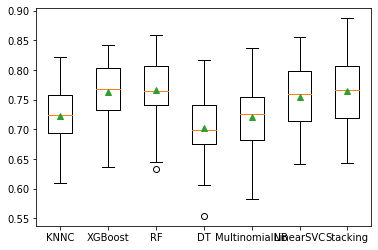

In [34]:
from matplotlib import pyplot
pyplot.boxplot(model_results, labels=names, showmeans=True)
pyplot.show()

In [35]:
model = create_stacking_models()
grid_search = model.fit(X_train,y_train)
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)
print("Testset Accuracy: %.2f%% " % (accuracy_score(y_test, y_test_pred)*100))
print("Classification Report of ",model_name,":\n",classification_report(y_test,y_test_pred))
print("Accuracy of stacking model",":",metrics.accuracy_score(y_test, y_test_pred))

Testset Accuracy: 78.04% 
Classification Report of  MultinomialNB :
               precision    recall  f1-score   support

           0       0.75      0.63      0.68        81
           2       0.79      0.87      0.83       133

    accuracy                           0.78       214
   macro avg       0.77      0.75      0.76       214
weighted avg       0.78      0.78      0.78       214

Accuracy of stacking model : 0.780373831775701


In [ ]:
#model with best parameters, some not used as there exists hyperparameter errors such as min_samples_split not found
# KNeighborsClassifier(n_neighbors=7)
# LogisticRegression(solver='newton-cg', penalty= 'l2', C= 10)
# DecisionTreeClassifier(min_samples_split= 11, min_samples_leaf= 1, max_features= 'sqrt', max_depth= 65, criterion= 'entropy')
# RandomForestClassifier(n_estimators= 100, min_samples_split= 10, min_samples_leaf= 2, max_features= 'sqrt', max_depth= 50, criterion= 'entropy', bootstrap= False)
# GradientBoostingClassifier(min_samples_split= 11, min_samples_leaf= 1, max_features= 'sqrt', max_depth= 65, criterion= 'entropy')
# LinearSVC()
# MultinomialNB(n_estimators= 50, min_samples_split= 9, min_samples_leaf= 1, max_features= 'sqrt', max_depth= 50, learning_rate= 0.05)